# Analysis
### This code analyzes tables with the following removed:
* **Multi** terrain type
* Any row that has null entries which was a consequence of scraping thousands of webpages with sometimes different table structures; this killed about 27% of the scraped data
* Chip time and gun time have been combined to form a minimum time in mins
* Deleted **ALL** races without the corresponding GPX file therefore this is the cross-referenced output
* Some GPX information has been added to tables, e.g. elevation and sigma

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
datadir = '/home/freddy/insight/data/'
filename = datadir + 'data_overlaps_with_gpx_cleaned.csv'
df = pd.read_csv(filename)
print('rows, cols = {0}, {1}'.format(df.shape[0], df.shape[1]))
df=df.drop(columns=['Unnamed: 0'], axis=1)

rows, cols = 31192, 13


In [3]:
df.head()

,age_group,position,race_title,sex,race_location,meeting_id,event_title,race_dist,min_time,sum_up,sigma,diff
0,U23,1.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.250000,51.8,9.01,-0.6
1,U23,2.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.450000,51.8,9.01,-0.6
2,SEN,3.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.550000,51.8,9.01,-0.6
3,SEN,4.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.733333,51.8,9.01,-0.6
4,V40,5.0,5M,M,Witham,257748,Witham Boxing Day 5,5.0,25.900000,51.8,9.01,-0.6


In [4]:
# Important maps
conversion_map = {'1M':1.0, '3K':1.86, '2M':2.0, '5K':3.1, '4M':4.0,
                 '5M':5.0, '6M':6.0, '10K':6.2, 'QM':6.55, '7M':7.0,
                 '10M':10.0, 'HM':13.1, 'Mar':26.2}
race_order= ['1M', '3K', '2M', '5K', '4M','5M', '6M', '10K',
             'QM', '7M', '10M', 'HM', 'Mar']
age_order = ['U15','U17','U20','U23','SEN','V35','V40','V45',
             'V50','V55','V60','V65','V70','V75','V80','V85']
#age_map = {'U11':0,'U13':0,'U15':0,'U17':0,'U20':0,'U23':0,
#           'SEN':1,'V35':2,'V40':2,'V45':3,'V50':3,'V55':4,
#           'V60':4,'V65':5,'V70':5,'V75':5,'V80':5,'V85':5}
age_map = {'U11':0,'U13':1,'U15':2,'U17':3,'U20':4,'U23':5,
                  'SEN':6,'V35':7,'V40':8,'V45':9,'V50':10,'V55':11,
                  'V60':12,'V65':13,'V70':14,'V75':15,'V80':16,'V85':17}
dist_map = {'1M':1, '3K':2, '2M':3, '5K':4, '4M':5,
            '5M':6, '6M':7, '10K':8, 'QM':9, '7M':10,
            '10M':11, 'HM':12, 'Mar':13}

In [5]:
#for idx,val in enumerate(age_order):
#    print('<option value="{0}">{1}</option>'.format(val,val))

In [6]:
df=df[df.age_group != 'V115']

In [7]:
df_old = df

In [8]:
df_old.groupby(['race_title'],as_index=False).size()

race_title
10K    15650
10M     2113
1M       199
2M        59
3K       421
4M       216
5K      2623
5M      4791
6M       272
7M       411
HM      3802
Mar      200
QM       434
dtype: int64

In [9]:
#df_old.groupby(['age_group'],as_index=False).size()

In [10]:
race_type = '10K'
df=df[df.race_title==race_type]
subdf=df[df.race_title==race_type].groupby(['meeting_id','sex','age_group','race_title'],as_index=False)['min_time'].median()

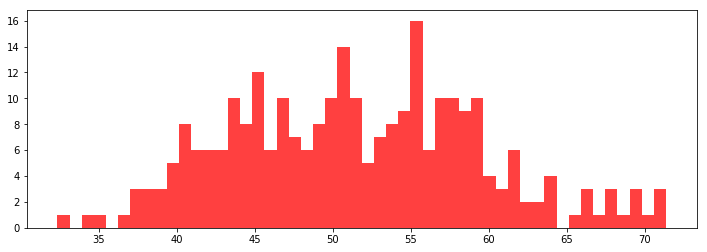

(array([  1.,   0.,   0.,   3.,   4.,   0.,   5.,   6.,   6.,   8.,   7.,
         11.,   8.,  13.,  11.,  12.,  15.,  12.,  16.,  18.,  11.,  15.,
         11.,  13.,  15.,  16.,  12.,  10.,  23.,  14.,  12.,  14.,   9.,
         11.,  11.,  11.,  10.,   6.,   5.,   6.,   7.,   7.,   7.,   8.,
          5.,   4.,   6.,  12.,   4.,   2.]),
 array([ 32.63333333,  33.45866667,  34.284     ,  35.10933333,
         35.93466667,  36.76      ,  37.58533333,  38.41066667,
         39.236     ,  40.06133333,  40.88666667,  41.712     ,
         42.53733333,  43.36266667,  44.188     ,  45.01333333,
         45.83866667,  46.664     ,  47.48933333,  48.31466667,
         49.14      ,  49.96533333,  50.79066667,  51.616     ,
         52.44133333,  53.26666667,  54.092     ,  54.91733333,
         55.74266667,  56.568     ,  57.39333333,  58.21866667,
         59.044     ,  59.86933333,  60.69466667,  61.52      ,
         62.34533333,  63.17066667,  63.996     ,  64.82133333,
         65.646666

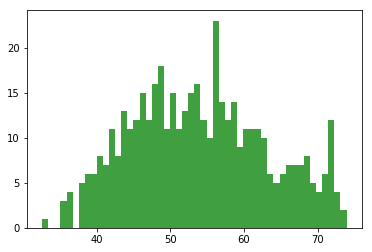

In [88]:
f, ax = plt.subplots(1,1, figsize=(12,4))
A=df.groupby(['event_title','min_time'], as_index=False).count()
Al = A[A.event_title=='RunThrough Chase The Moon Olympic Park 10K']
plt.hist(list(Al.min_time.values), 50,facecolor='r',
         alpha=0.75)
plt.show()

Ar = A[A.event_title=='RunThrough Olympic Park 10K']
plt.hist(list(Ar.min_time.values), 50,
                            facecolor='g', alpha=0.75)


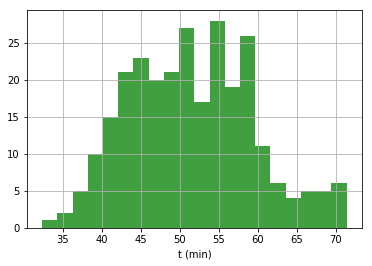

In [11]:
location_df = df.groupby(['meeting_id','race_location','event_title'],as_index=False).count()
events = set(list(location_df['event_title'].values))

event_map = {}
for i in events:
    subdf = location_df.loc[location_df['event_title']==i]
    subdf_map = {}
    for index, row in subdf.iterrows():
        ID  = row.meeting_id
        loc = row.race_location
        subdf_map[ID] = loc
    event_map[i] = subdf_map
temp = dict(zip(location_df.meeting_id,location_df.event_title))

In [12]:
#print(temp)

In [13]:
id_avgtime = df.groupby(['meeting_id'], as_index=False)['min_time'].median()
times = dict(zip(id_avgtime.meeting_id, id_avgtime.min_time))
time_bar = 0.0
for i in list(times.values()):
    time_bar += i
time_bar /= float(len(list(times.values())))

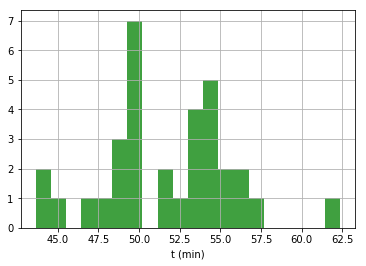

In [14]:
n, bins, patches = plt.hist(times.values(), 20,
                            facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('t (min)')
plt.show()

In [15]:
def get_dt(row):
    time = row.min_time
    med_time = times[row.meeting_id]
    return float(time-med_time)

In [16]:
DT_CUT = 20.
df['dt'] = df.apply(get_dt,axis=1)
print(df.shape)
df = df.drop(df[df.dt > DT_CUT].index)
print(df.shape)

(15650, 13)
(15099, 13)


In [17]:
Y = []
for index,row in df.iterrows():
    sex  = row.sex
    age  = row.age_group
    time = row.min_time 
    ID   = row.meeting_id
    # Need a smarter method for this...I tried building a dictionary like I would
    # normally do in C++ but it doesn't work that way in python to my knowledge
    #temp_row = subdf.loc[(subdf['age_group']==age) & 
    #                     (subdf['sex']==sex) &
    #                     (subdf['meeting_id'] == ID)]
    #avg_time = (temp_row.min_time).item()
    avg_time = times[ID]
    Y.append(0 if (time<=avg_time) else 1)

In [18]:
Y_dt = list(df['dt'])

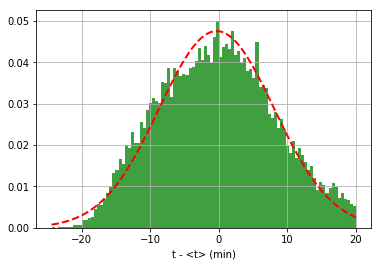

Mu,sigma = -0.325, 8.383


In [20]:
from scipy.stats import norm
n, bins, patches = plt.hist(Y_dt, 100, density=True, 
                            facecolor='g', alpha=0.75)
#plt.axis([10, 35, 0.0, 0.175])
plt.grid(True)
plt.xlabel('t - <t> (min)')
(mu,sig) = norm.fit(Y_dt)
y = mlab.normpdf(bins, mu, sig)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.show()
print('Mu,sigma = %1.3f, %1.3f' % (mu,sig))

In [21]:
X = df

In [22]:
norm = conversion_map[race_type]
X['sum_up'] = X['sum_up']/norm
X['sigma']  = X['sigma']/norm
print('Normalization = %1.4f miles' % norm )

Normalization = 6.2000 miles


In [23]:
gpx = X.groupby(['meeting_id'],as_index=False).mean()
gpx = gpx.drop(['position', 'race_dist', 'min_time'], axis=1)

In [24]:
X = X.drop(['position','meeting_id', 'race_title', 'race_dist',
            'event_title','race_location', 'dt'], axis=1)

In [25]:
for xrow in [X]:
    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 2} ).astype(int)
    xrow['age_group'] = xrow['age_group'].map( age_map )

## Logistic Regression
This was attempt number 1 and too simple as the output has been forced to be binary

In [ ]:
clf = LogisticRegression()
clf.fit(X, Y)
beta = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
print('Logistic Regression Results:')
print(beta)

In [26]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y_dt)
lr = reg.coef_
beta_dict = {'age_group': lr[0], 'sex':lr[1], 
             'min_time':lr[2], 'sum_up':lr[3], 'sigma':lr[4],
            'diff':lr[5]}
beta = pd.DataFrame(list(beta_dict.items()))
print('Linear Regression Results:')
print(beta)

Linear Regression Results:
           0         1
0  age_group  0.232523
1        sex -0.669132
2   min_time  0.812980
3     sum_up -0.067182
4      sigma -0.109260
5       diff  0.020412


In [27]:
d = []
for index, row in X.iterrows():
    rowidx=0
    sum = 0.0
    for i in row:
        sum += i*beta.values[rowidx][1]
        rowidx+=1
    if row.min_time>75:
        continue
    d.append(sum)

Mu,sigma = 40.728, 7.643


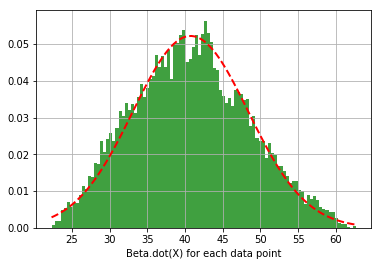

In [28]:
from scipy.stats import norm
n, bins, patches = plt.hist(d, 100, density=True, 
                            facecolor='g', alpha=0.75)
#plt.axis([20, 120, 0.1, 200])
plt.grid(True)
plt.xlabel('Beta.dot(X) for each data point')
(mu,sig) = norm.fit(d)
y = mlab.normpdf(bins, mu, sig)
l = plt.plot(bins, y, 'r--', linewidth=2)
#plt.yscale('log')
print('Mu,sigma = %1.3f, %1.3f' % (mu,sig))
plt.show()

In [29]:
def integrate(lo, hi, n, bins):
    integral = 0.0
    for idx in range(lo,hi):
        integral += n[idx] * (bins[idx+1]-bins[idx])
    return integral

In [41]:
xvals, yvals, dx = [],[],[]
for idx in range(0,len(n)):
    integral = integrate(0, idx, n, bins)
    binpos =  0.5*(bins[idx+1] + bins[idx])
    dx.append(bins[idx+1] - bins[idx])
    success = False
    if integral > 0.995:
        success = True
        integral = 1.0
    xvals.append(binpos)
    yvals.append(integral)
    if success:
        break

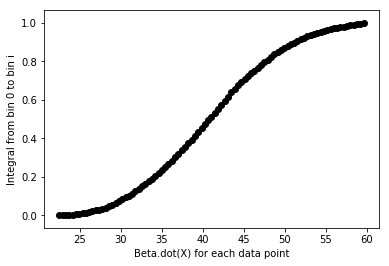

In [42]:
plt.scatter(xvals,yvals,color='black')
plt.xlabel('Beta.dot(X) for each data point')
plt.ylabel('Integral from bin 0 to bin i')
plt.show()

In [43]:
#dump_output = 'inputs/{0}/'
dump_output = 'inputs/testing/10K/'

In [44]:
# save the betas
beta.to_csv('{0}beta_{1}.csv'.format(dump_output,race_type),sep=',', 
            index=False, header=False)

In [45]:
# Write out the integral plot
f = open('{0}d_dist_{1}.csv'.format(dump_output,race_type), 'w')
f.write('bin,xval,yval,dx\n')
for idx in range(0,len(xvals)):
    f.write('%d,%1.5f,%1.5f,%1.5f\n' % (idx,xvals[idx],yvals[idx], dx[idx]))
f.close()

In [46]:
# Write out the averaged time bands
#for xrow in [subdf]:
#    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 2} ).astype(int)
#    xrow['age_group'] = xrow['age_group'].map( age_map )
#subdf.to_csv('{0}avg_times_{1}.csv'.format(dump_output,race_type),sep=',',
#            index=False)
id_avgtime.to_csv('{0}avg_times_{1}.csv'.format(dump_output,race_type),sep=',',
            index=False)

In [47]:
# Write out the GPX information used
gpx.to_csv('{0}gpx_info_{1}.csv'.format(dump_output,race_type),sep=',', index=False)

In [48]:
# Print out age and sex map
f1 = open('{0}age_map_{1}.csv'.format(dump_output,race_type), 'w')
for key, val in age_map.items():
    f1.write('%s,%d\n'%(key,val))
f1.close()

In [49]:
# Print out the event list
f2 = open('{0}event_title_list_{1}.csv'.format(dump_output,race_type), 'w')
f2.write('event\n')
for key, val in event_map.items():
    f2.write('%s\n'%key)
f2.close()

In [50]:
f3 = open('{0}event_title_list_v2_{1}.csv'.format(dump_output,race_type), 'w')
f3.write('ID,event\n')
for key, val in temp.items():
    f3.write('%d,%s\n'%(key,val))
f3.close()

In [51]:
input_dir = '/home/freddy/insight/letsdothis/inputs/'
input_evts  = race_type + '/event_title_list_v2_' + race_type + '.csv'
events_df = pd.read_csv(input_dir+input_evts)
events = dict(zip(events_df.ID,events_df.event))